In [1]:
# ===============================================
# 📦 STEP 1: Install Required Packages
# ===============================================
!pip install roboflow insightface onnxruntime faiss-cpu opencv-python-headless matplotlib scikit-learn tqdm

# ===============================================
# 📥 STEP 2: Download Dataset from Roboflow
# ===============================================
from roboflow import Roboflow
rf = Roboflow(api_key="T28ISrZu4i9dqlVk8YT6")
project = rf.workspace("arif-m-u3kjz").project("face-tlml4")
version = project.version(1)
dataset = version.download("folder")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 7.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

In [17]:
# ✅ 1. Install the updated SDK
!pip install -U pinecone-client


In [6]:
# ===============================================
# 🧠 STEP 3: Load Face Embedding Model (InsightFace)
# ===============================================
import insightface
from insightface.app import FaceAnalysis

app = FaceAnalysis(name="buffalo_l", providers=['CPUExecutionProvider'])  # Use 'CUDAExecutionProvider' for GPU
app.prepare(ctx_id=0)


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


In [7]:
# ===============================================
# 🏷️ STEP 4: Batch Process Embeddings (10 at a time)
# ===============================================
import os
import numpy as np
import cv2
from tqdm import tqdm

embedding_list = []
label_list = []

data_dir = "/content/Face-1/train"
batch_size = 10

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    img_names = os.listdir(class_path)

    print(f"\nProcessing class: {class_name} ({len(img_names)} images)")
    for i in tqdm(range(0, len(img_names), batch_size)):
        batch = img_names[i:i+batch_size]
        for img_name in batch:
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            faces = app.get(img)
            if faces:
                emb = faces[0].embedding
                embedding_list.append(emb)
                label_list.append(class_name)

embedding_list = np.array(embedding_list).astype('float32')
print("✅ Embedding extraction complete.")



Processing class: 02 (979 images)


100%|██████████| 98/98 [17:06<00:00, 10.48s/it]



Processing class: 04 (980 images)


100%|██████████| 98/98 [16:48<00:00, 10.29s/it]



Processing class: 01 (960 images)


100%|██████████| 96/96 [17:59<00:00, 11.25s/it]



Processing class: 05 (992 images)


100%|██████████| 100/100 [17:39<00:00, 10.60s/it]



Processing class: 03 (984 images)


100%|██████████| 99/99 [18:07<00:00, 10.98s/it]



Processing class: 06 (955 images)


100%|██████████| 96/96 [17:37<00:00, 11.02s/it]

✅ Embedding extraction complete.


Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.


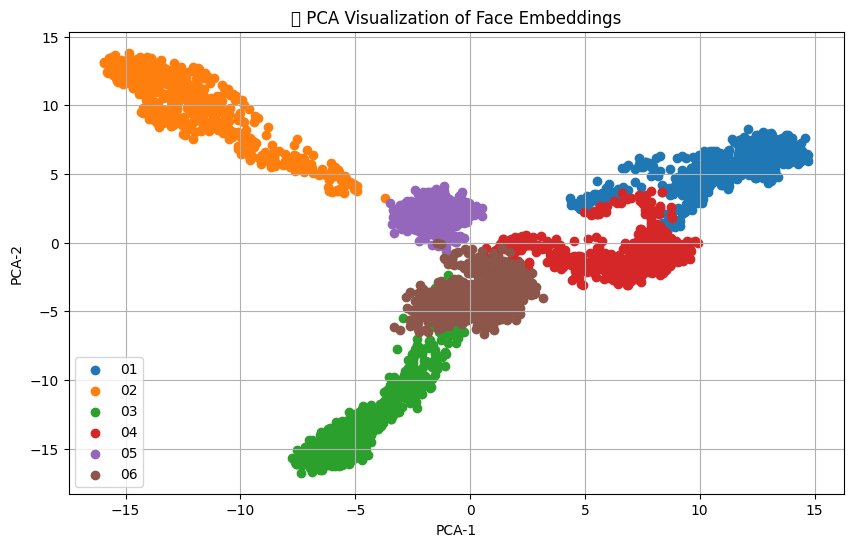

In [10]:
# ===============================================
# 📊 STEP 5: Visualize Embeddings (PCA & t-SNE)
# ===============================================
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Encode labels
unique_labels = sorted(set(label_list))
label_to_idx = {label: i for i, label in enumerate(unique_labels)}
numeric_labels = [label_to_idx[label] for label in label_list]

# PCA Visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embedding_list)

plt.figure(figsize=(10, 6))
for i, label in enumerate(unique_labels):
    idxs = [j for j, l in enumerate(label_list) if l == label]
    plt.scatter(pca_result[idxs, 0], pca_result[idxs, 1], label=label)
plt.legend()
plt.title("📉 PCA Visualization of Face Embeddings")
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.grid(True)
plt.show()


'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.


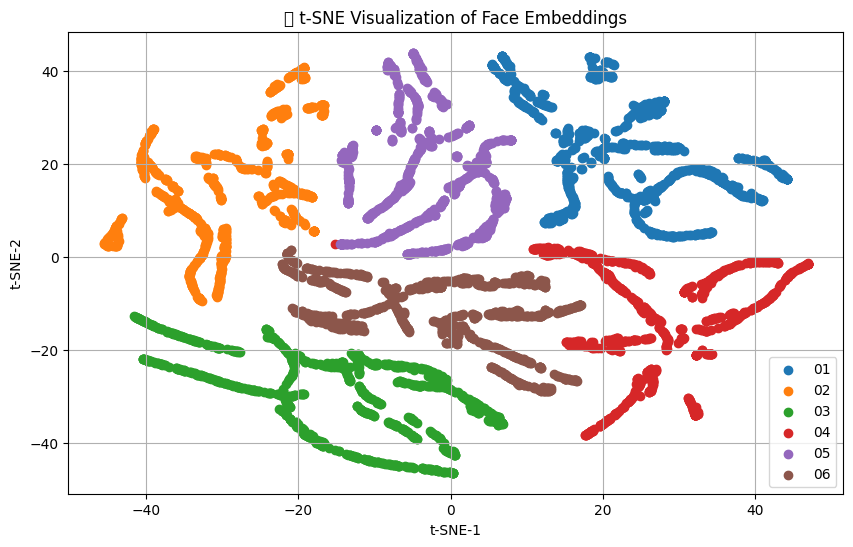

In [11]:
# Optional: t-SNE Visualization (Slower but detailed)
tsne = TSNE(n_components=2, perplexity=30, n_iter=500, random_state=42)
tsne_result = tsne.fit_transform(embedding_list)

plt.figure(figsize=(10, 6))
for i, label in enumerate(unique_labels):
    idxs = [j for j, l in enumerate(label_list) if l == label]
    plt.scatter(tsne_result[idxs, 0], tsne_result[idxs, 1], label=label)
plt.legend()
plt.title("📉 t-SNE Visualization of Face Embeddings")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.grid(True)
plt.show()


In [12]:
# ===============================================
# 💾 STEP 6: Save Embeddings & Labels
# ===============================================
np.save("face_embeddings.npy", embedding_list)
np.save("face_labels.npy", np.array(label_list))

print("✅ Saved embeddings and labels.")


✅ Saved embeddings and labels.


In [20]:
# ✅ 2. Setup and upload embeddings
import os
from pinecone import Pinecone, ServerlessSpec

# 🔁 Replace with your actual API key and region
api_key = "pcsk_r8vKE_NHyBumzqjUcvYp7DDXu7HSqM4QP8iAvr9UmeBcJ5cU2fbWgmQY2r9R864hXNRjQ"
region = "us-east-1"

# ✅ 3. Initialize Pinecone client
pc = Pinecone(api_key=api_key)

# ✅ 4. Create index if not exists
index_name = "face-embeddings"

if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=512,
        metric="cosine",  # or "euclidean" or "dotproduct"
        spec=ServerlessSpec(cloud="gcp", region="us-west1")
    )

# ✅ 5. Connect to index
index = pc.Index(index_name)

# ✅ 6. Upload embeddings (chunked if large)
items = [
    (f"id-{i}", embedding_list[i].tolist(), {"label": label_list[i]})
    for i in range(len(embedding_list))
]

# Upload in batches (recommended)
batch_size = 100
for i in range(0, len(items), batch_size):
    index.upsert(items[i:i+batch_size])

print("✅ Embeddings uploaded to Pinecone!")


✅ Embeddings uploaded to Pinecone!


In [21]:
import numpy as np

# Load embeddings and labels
embedding_list = np.load("face_embeddings.npy")
label_list = np.load("face_labels.npy")

# Upload to Pinecone
items = [
    (f"id-{i}", embedding_list[i].tolist(), {"label": label_list[i]})
    for i in range(len(embedding_list))
]

# Upload in batches to avoid timeout
batch_size = 100
for i in range(0, len(items), batch_size):
    batch = items[i:i+batch_size]
    index.upsert(batch)

print("✅ Uploaded all face embeddings to Pinecone.")


✅ Uploaded all face embeddings to Pinecone.


In [22]:
def recognize_face(face_embedding):
    query_result = index.query(
        vector=face_embedding.tolist(),
        top_k=1,
        include_metadata=True
    )
    match = query_result["matches"][0]
    label = match["metadata"]["label"]
    score = match["score"]
    return label, score


In [26]:
import cv2
from insightface.app import FaceAnalysis

# Load InsightFace model
app = FaceAnalysis(name="buffalo_l", providers=['CPUExecutionProvider'])
app.prepare(ctx_id=0)

# Recognize face from Pinecone
def recognize_face(face_embedding):
    query_result = index.query(
        vector=face_embedding.tolist(),
        top_k=1,
        include_metadata=True
    )
    if query_result["matches"]:
        match = query_result["matches"][0]
        return match["metadata"]["label"], match["score"]
    return "No match", 0.0

# Run recognition from image
def recognize_from_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return "Image not found", 0.0
    faces = app.get(img)
    if not faces:
        return "No face found", 0.0
    emb = faces[0].embedding
    label, score = recognize_face(emb)
    return label, score

# ✅ Use your image path
test_img = "/content/WhatsApp Image 2025-05-10 at 01.37.47 (1).jpeg"
label, score = recognize_from_image(test_img)
print(f"✅ Recognized as: {label} (Similarity Score: {score:.4f})")


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
✅ Recognized

In [28]:
import cv2
from insightface.app import FaceAnalysis

# Load InsightFace model
app = FaceAnalysis(name="buffalo_l", providers=['CPUExecutionProvider'])
app.prepare(ctx_id=0)

# Pinecone search function
def recognize_face(face_embedding):
    query_result = index.query(
        vector=face_embedding.tolist(),
        top_k=1,
        include_metadata=True
    )
    if query_result["matches"]:
        match = query_result["matches"][0]
        return match["metadata"]["label"], match["score"]
    return "No match", 0.0

# Image face recognition
def recognize_from_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return "Image not found", 0.0
    faces = app.get(img)
    if not faces:
        return "No face found", 0.0
    emb = faces[0].embedding
    label, score = recognize_face(emb)
    return label, score

# List of test images
test_images = [
    "/content/class_1.jpeg",
    "/content/02.jpeg",
    "/content/class_03.jpeg",
    "/content/class_04.jpeg",
    "/content/class_05.jpeg",
    "/content/class_06.jpeg"
]

# Run batch recognition
for i, img_path in enumerate(test_images):
    label, score = recognize_from_image(img_path)
    print(f"[Image {i+1}] ✅ Recognized as: {label} (Similarity Score: {score:.4f})")


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
[Image 1] ✅ 

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


<IPython.core.display.Javascript object>

✅ Recognized as: 05 (Score: 0.6832)


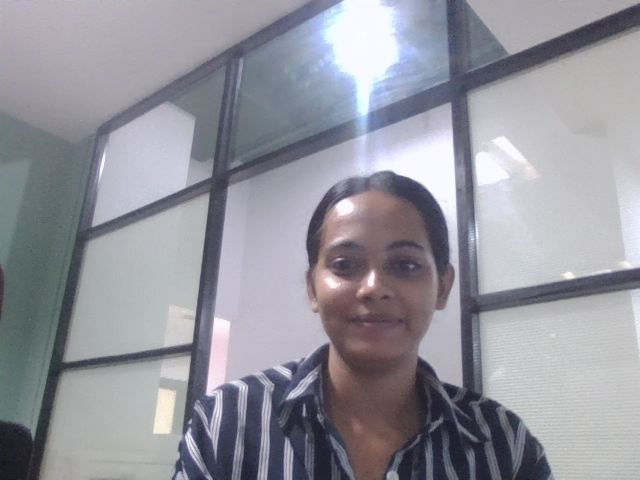

In [38]:
from IPython.display import display, Javascript
from google.colab import output
from base64 import b64decode
from insightface.app import FaceAnalysis
import cv2
import numpy as np
from pinecone import Pinecone
from google.colab.patches import cv2_imshow

# Initialize Pinecone
api_key = "pcsk_r8vKE_NHyBumzqjUcvYp7DDXu7HSqM4QP8iAvr9UmeBcJ5cU2fbWgmQY2r9R864hXNRjQ"
index_name = "face-embeddings"
pc = Pinecone(api_key=api_key)
index = pc.Index(index_name)

# Load model
app = FaceAnalysis(name="buffalo_l", providers=["CPUExecutionProvider"])
app.prepare(ctx_id=0)

# JS to capture photo
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
      async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = '📸 Capture';
        div.appendChild(capture);
        document.body.appendChild(div);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        document.body.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Resize the output to fit the video element
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getTracks().forEach(track => track.stop());
        video.remove();
        capture.remove();

        const dataUrl = canvas.toDataURL('image/jpeg', quality);
        return dataUrl;
      }
    ''')
    display(js)
    data = output.eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Pinecone face recognition
def recognize_face(face_embedding):
    query_result = index.query(
        vector=face_embedding.tolist(),
        top_k=1,
        include_metadata=True
    )
    if query_result["matches"]:
        match = query_result["matches"][0]
        return match["metadata"]["label"], match["score"]
    return "No match", 0.0

# Take photo and run recognition
filename = take_photo()
img = cv2.imread(filename)

faces = app.get(img)
if not faces:
    print("❌ No face detected.")
else:
    emb = faces[0].embedding
    label, score = recognize_face(emb)
    print(f"✅ Recognized as: {label} (Score: {score:.4f})")

    # Optional: Show captured face
    cv2_imshow(img)
